## Russian Trolls Detector

In [14]:
from plot_helper import plot_model_eval  # Helper functions for plotting
import random  # Used to select random samples from a dataset.
import glob  # This * symbol is called the glob symbol, like * in terminal.
import pandas as pd  # DataFrame support

### Interest

Since 2015 the internet has had an influx of Russian Political Trolls that spread political misinformation often linking to fake news sites.  They're all over youtube, twitter, facebook, and other social media sites.

If I can analyze these bots, it might be possible to create a Political Troll Detector.

### Getting The Dataset

I first looked for youtube datasets, but could not find any.  Luckily, Twitter has a dataset of Russian Trolls that can be found at https://github.com/fivethirtyeight/russian-troll-tweets/

"This directory contains data on nearly 3 million tweets sent from Twitter handles connected to the Internet Research Agency, a Russian "troll factory" and a defendant in an indictment filed by the Justice Department in February 2018, as part of special counsel Robert Mueller's Russia investigation."

The dataset was created by analysts who manually flagged russian troll accounts to a strict criteria.  More information can be found http://pwarren.people.clemson.edu/Linvill_Warren_TrollFactory.pdf on page 5, Data Analysis.

### Feature Engineering

If I want to classify a tweet as a troll or not, the best way is to do some advanced feature engineering.  I started brainstorming hypothetical features that might work well for classification:

- Icon / Avatar
    + profile/background image, description
        * There is a high chance a paid troll will not care to setup their background image.
    + no evidence of personal life in its profile page,
- ratio of followers to following (twitter)
    + quantity of favorites / liked / similar (youtube)
- identical comment between different users
- length of comment
- ratio of response to non-followers to respond to followers (twitter)
- sentiment analysis
- Identify speakers original language using stop words.
- Spelling errors.
- account creation date
- average number of posts
- std of posts
- avg ratio or response to non-response posts
- avg retweet rate

Unfortunately, time has passed since 2015 and the accounts of the russian trolls have most likely been deleted.  This leaves feature engineering difficult, at best, unless new troll accounts can be identified first.

### NLP

Natural Language Processing is a technique that identifies topics within text.

Thankfully the Dataset has the flagged tweet and category to classify, which is enough for NLP, so NLP seems like the logical next step.

I could do the traditional NLP path which involves quite a bit of work.  Here is the NLP brainstorming notes I took of potential tasks that would need to be done:

- tokenize to words -> dictionary
    + WordPunctTokenizer
- remove punctuation and non-alphabetic characters
    + Also, toLowercase
- both "lemmas and stems"
- Bag of Words / word embedding
    - word2vec
    - (n-grams) feature vector where a feature is all words and phrases, and the feature value is the frequency of occurrence
    - (tf-idf technique) term-document matrix and word count
- remove stop words
    - Specifically, remove both most popular and least popular words.
    - filter tokens /w length <= 1 and > 14
- topic model / chunking
    - LDA (most common)
        + LDA / chunking is used to create features, useful for categorization.  We want prediction, so LDA by itself isn't ideal.
    - sLDA (supervised LDA)
        + Topics most likely change over time, so if I want to use this I will have to bucket tweets by date.
- sentiment analysis
    - Fine-grained Sentiment Analysis
    - Emotion detection
    - Intent analysis
    * two primary types of sentiment analysis:
        + machine learning
        + lexicon
        + hybrid
    1) convert to frequency of words (bag-of-words or bag-of-ngrams)
    2) ML, eg: bayes, logistic regression, SVM, NNs
        + Bernoulli Naive Bayes and Logistic Regression has previously scored the highest when it comes to classifying tweets.
    3) Can be trained using preclassified Twitter sentiment data.  Kaggle has such a dataset.
- bi-LSTM
    + word vectors can be then put into an lstm
    + slow to train
    + needs lots of examples
        - 10 million to 100 million entries is a good idea, which can take weeks to pre-train.
    + doesn't know syntax of sentence (it has to learn it)
    + Might want to try alternative models that need less training data first.

### Enter the Jetson TX2

Most of the NLP tasks above are CPU bound, except the bi-LSTM.  The TX2 has a 2ghz arm processor that is not ideal for this kind of work.  Running these CPU tasks could days or even weeks on the TX2.  Where the TX2 shines is it's gpu, so it is ideal to do as much work as possible on the gpu.  Thankfully, there are new NLP techniques that do just that.

### A New Way To Do NLP

Traditionally, pre-processing and tokenization is performed over the dataset then a bi-lstm neural network is used to learn the language.  This works quite well, but millions of entries are needed, and even using the TX2's gpu, it would take about 6 weeks to train a base dataset of 10 million tweets.

Since 2018 there has been a new type of learning called self-supervised learning.  This allows for a neural network to be pre-trained on a language, and then trained on much smaller datasets.  There are new kinds of self-supervised neural networks for the purpose of NLP based tasks.

### Enter Bert

Bert is the first mainstream self-supervised neural network designed by Google for NLP tasks from question and answer to sentiment analysis to classification.  Bert stands for Bidirectional Encoder Representations From Transformers.

Bert comes pre-trained on Wikipedia giving it a great understanding of the English language.  Also, new advances have been made with Bert beyond a traditional bi-lstm: 

- byte-pairing
    + split words into parts of words and have a count for that
    + vs prev where entire dictionary has a freq count
- transformer
    + Like a feed forward CNN but into an RNN
    + input text and position embedding -> text prediction / text classification
    + because like CNN it takes in neighboring context at the same time

Google is calling Bert the next big jump in ML since the CNN.  Bert has lead to a massive jump in word comprehension above and beyond previous methods.  Likewise, you don't need 10 million+ entries to train it, as it comes pre-trained on Wikipedia data.  It's an exciting time for NLP.

Because Bert takes in bidirectional representation, n-grams, word vectors, and similar bagging of words are no longer necessary.  Most of the CPU bound NLP tasks are removed.  All that is necessary is basic word tokenization and everything else can be done on the GPU.

However, there is one big problem.  Upon attempting to use BERT on the TX2, BERT requires roughly 12GB of vram, and the TX2 has 8GB of shared system ram.  Thankfully, there is a modern alternative that requires less vram.

### Albert

Albert stands for A Lite Bert.  ALBERT has an 89% parameter reduction with only a minor drop in performance — 80.3 SQuAD2.0 score, down from 80.4; or 67.9 on RACE, down from 68.2.

Using Albert Base, with a max sentence length of 280 characters, and a batch size of 8, Albert requires roughly 3.3 GB of vram, which the tx2 has the resources for.

Because of all of the factors listed above, I chose Albert over the classic NLP techniques.

### Setting up Albert on the Jetson TX2

The initial attempt did not go so well.  Albert requires Tensorflow version 1.15 and the TX2 has version 1.13 installed on it.  The version of Jetpack on the TX2 supported 1.15 so I upgrading Tensorflow, which succeeded except certain base packages Tensorflow needed needed to updated as well.  This quickly became a mess.

Alternatively, the newest version of Jetpack (the Jetson's OS) has Tensorflow 1.15 out of the box, so I decided to update the TX2 to the newest version of Jetpack.  This required formatting the TX2 and setting it up from scratch, which is probably ideal, as there is severe ram restrictions on the TX2 to run Albert, so the lighter the system the better.  After updating Jetpack, Tensorflow worked correctly and Albert was able to run.

However, I ran into memory errors left and right.  Tensorflow is not designed to run on a shared memory system.  Tensorflow is designed to monopolize vram available to speed up the task at hand which causes Tensorflow to take up all of the available system ram, crashing the TX2.

Thankfully, there is a solution.  Tensorflow has the option to allocate vram only when needed.  Turning this option on is a hard requirement to get the TX2 working on Tensorflow.

In [15]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow GPU memory
set_session(tf.Session(config=config))

To enable the option to allocate vram only when needed, this code has been added to `ALBERT/run_classifier.py` starting at line 32.

### Initial Test Run

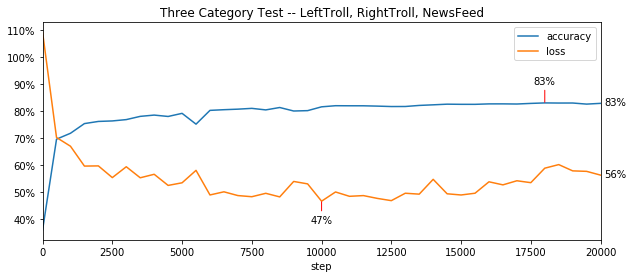

In [16]:
plot_model_eval('out/1', "Three Category Test -- LeftTroll, RightTroll, NewsFeed")

In [17]:
# This will take a minute to process
folder = "data/russian-troll-tweets-master"
russian_tweets = pd.concat([pd.read_csv(file, dtype='str') for file in glob.glob(folder + '/*.csv')])

pd.set_option('max_colwidth', 280) # 280 max characters in a Tweet

# User CANNONSHER randomly selected to remove bias.  10-20 selected to show both troll tweets and normal tweets.
pd.DataFrame(russian_tweets[russian_tweets['author'] == 'CANNONSHER'].iloc[10:20]['content'])

,content
229305,Ain't there a dude on one of those Real Housewives shows that dyed all his hair gray?
229306,#DylannRoof has been sentenced to DEATH! #CharlestonChurchshooting #DylannRoofTrial #NeverForget #Justice https://t.co/qalABkplFJ
229307,Every girl needs some lace in her life to be queen ��� Shop ➵ https://t.co/xW3gvOHODe https://t.co/b6LS2pS8VG
229308,Ummmm. � https://t.co/8Okm0S2OHb
229309,It's so many crazy sexual relationships in this Celia show...like HOW?
229310,I want some loaded baked potato spring rolls.
229311,"A man is a success if he gets up in the morning and gets to bed at night, and in between he does what he wants to do."
229312,"The TEAM, not the individual, is the ultimate champion!"
229313,It is sometimes an appropriate response to reality to go insane
229314,If you are shooting for the stars then i guess you're aiming at me – J.Cole


Trolls will write many normal tweets along side troll tweets, some pretending to be a reporter.  Therefore, the Russian Troll Dataset is not classifying individual tweets as troll or not.  The dataset is flagging accounts found with enough troll tweets on them to flag the entire account.

Albert is only classifying tweet by tweet.  No account information is processed.  Given this difficulty, I'm surprised how well Albert is doing.  83% accuracy is excellent, on par or possibly better than a person could do.

This shows another category is necessary, a non-troll non-news category.  From here on out, Albert will be trained on 4 categories.

### Custom Vocabulary

Albert is pre-trained on Wikipedia, so vocabulary used on Twitter may differ from Wikipedia.  Eg, Wikipedia may not have MAGA in it's vocabulary.  Therefore, it makes sense to train a custom vocabulary file to run.

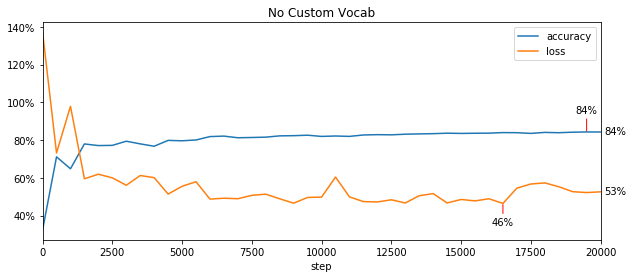

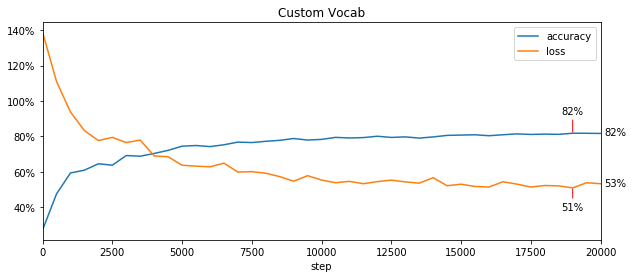

In [19]:
plot_model_eval('out/5', "No Custom Vocab")
plot_model_eval('out/7', "Custom Vocab")

An accuracy of 84% is excellent.

Surprisingly, the Twitter vocabulary file I made for Albert is worse than the Wikipedia vocabulary file.

In [20]:
def read_sentencepiece_vocab(filepath):
  voc = []
  with open(filepath, encoding='utf-8') as fi:
    for line in fi:
      voc.append(line.split("\t")[0])
  # skip the first <unk> token
  voc = voc[1:]
  return voc

twitter_vocab = read_sentencepiece_vocab("data/vocab/twitter-30k.vocab")
random.seed(124)
print("Sample tokens: {}".format(random.sample(twitter_vocab, 20)))

Sample tokens: ['pkk', '▁indonesian', 'my', 'span', 'kpxt', 'nka', 'jcz', '▁apologist', '▁wives', '▁arrest', 'lur', 'yan', 'kav', 'prof', 'bender', 'ksd', 'king', 'operation', 'mkr', 'cbx']


Performing EDA over the the twitter vocabulary presents a glaring issue.  The Twitter vocabulary file has spelling errors running throughout it.

It is possible to create an improved vocabulary file.  A couple of solutions come to mind:

- Create a vocabulary file from the comments in https://reddit.com/r/politics.  Much, if not all, of the same vocabulary is used by the Russian Trolls, and spelling errors are rare on Reddit.  This, despite not being Twitter, I expect would work quite well.
    + I could use the generated vocabulary to spell check tweets which could further increase accuracy.
- Double check the vocabulary file format.  I followed the instructions on the Albert github repo on how to generate a vocabulary file, but the format is slightly different than the vocabulary file Albert comes with.
- Double check the spm file that is generated when the vocabulary file is generated.
- It could be vocabulary and pre-training are tied, so Albert needs to be pre-trained, which would hours on Google Colab, but would take about 6 weeks on the TX2.

Due to time constraints, I was not able to pursue this avenue.  It takes 3 days on the TX2 to generate a plot with a step size of 20,000.  I imagine there is gold to be had by exploring this path further.

### Changes Over Time

If I want to make a russian political troll detector, it is ideal to identify model accuracy over time.  How much of the troll topics are changing over the years and how much stays the same?

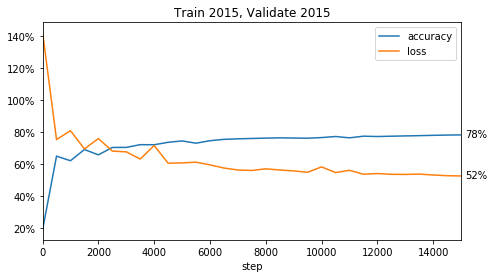

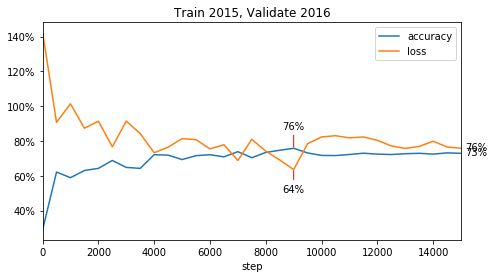

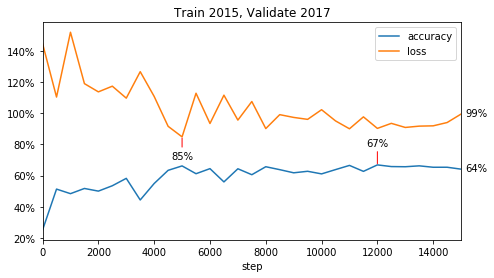

In [21]:
plot_model_eval('out/8', "Train 2015, Validate 2015")
plot_model_eval('out/9', "Train 2015, Validate 2016")
plot_model_eval('out/10', "Train 2015, Validate 2017")

Unfortunately, the change over time is more drastic than I had expected.

Most of the troll tweets mask themselves as news and link to websites with fake news.  Trying to identify a pattern between fake news and real news is showing to be difficult.

I'm not satisfied with these results.  More needs to be done before an accurate political troll detector can be made.

### Looking Forward

- Pouring over the dataset and seeing if any troll accounts still exist is an excellent next step.  If any troll accounts still exist, a new dataset can be made from current tweets.  This would allow for feature engineering on the troll account which would significatly increase classification accuracy.

- Pre-training would take over 6 weeks on the TX2 but it could boost model performance significantly.  Fake news tweets are often written by someone who English is not their first language and they're attempting to write pseudo news story titles.  Fake news story titles is not like Wikipedia English, so pre-training could go a long way.

- Another path forward is using Albert to flag potential troll tweets.  Accounts of flagged troll tweets can have their older tweets checked for troll activity.  If a significant number of tweets get flagged on the same account, the tweets in question can be verified.
    + Albert's initial accuracy may be somewhat low, but flagged user accounts can have a high accuracy.  This allows Albert to find new troll tweets to be trained on.

### Noteworthy

Political trolls often link to fake news sites.  If the techniques mentioned above works and new trolls can be identified, then this project can be used to identify new fake news sites as they appear online.

### Personal Notes

I spent 1 day setting up the TX2 to work with Albert, about 2 days writing journal code, and over a week training models.

I can productionize this project and create a political troll detector website that shows caught accounts and lets the user paste in suspected accounts to check.  I originally considered doing this, but given Albert's current accuracy I feel it is wiser to improve model performance first.

### Sources

- How Bert works under the hood.
    + https://youtu.be/OR0wfP2FD3c
- twitter trolls vs humans
    + https://arxiv.org/pdf/1901.11162.pdf
- Analysing Russian Trolls via NLP
    + https://arxiv.org/pdf/1911.11067.pdf
- Youtube, NLP, sentiment analysis (For future goals.)
    + https://www.researchgate.net/publication/321408074_Retrieving_YouTube_video_by_sentiment_analysis_on_user_comment/link/5d36e3904585153e5919a034/download
- State of ML in the industry
    + Explains cutting edge, eg self-supervised learning and Bert, and where the industry is going.
    + https://medium.com/syncedreview/aaai-2020-whats-next-for-deep-learning-hinton-lecun-and-bengio-share-their-visions-e29385dcaed5